In [1]:
%autosave 0

Autosave disabled


### 0. Dependencies

In [2]:
# Linear algebra and data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Kmeans
from sklearn.cluster import KMeans

# Pipelining
from sklearn.pipeline import make_pipeline

The goal is to form similary developed groups of countries on the basis of given variables.

Data source: https://www.kaggle.com/datasets/vipulgohel/clustering-pca-assignment

# <center>1. Data Overwiew</center>

In [3]:
df = pd.read_csv('Country-data.csv')
df.set_index('country', inplace=True)

In [4]:
df

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
country,,,,,,,,,
Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200
...,...,...,...,...,...,...,...,...,...
Vanuatu,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970
Venezuela,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500
Vietnam,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310


In [5]:
data_dict = pd.read_csv('data-dictionary.csv')
for index in data_dict.index:
    print('{}\n info: {}\n'.format(data_dict.loc[index, 'Column Name'], data_dict.loc[index, 'Description']))

country
 info: Name of the country

child_mort
 info: Death of children under 5 years of age per 1000 live births

exports
 info: Exports of goods and services. Given as %age of the Total GDP

health
 info: Total health spending as %age of Total GDP

imports
 info: Imports of goods and services. Given as %age of the Total GDP

Income
 info: Net income per person

Inflation
 info: The measurement of the annual growth rate of the Total GDP

life_expec
 info: The average number of years a new born child would live if the current mortality patterns are to remain the same

total_fer
 info: The number of children that would be born to each woman if the current age-fertility rates remain the same.

gdpp
 info: The GDP per capita. Calculated as the Total GDP divided by the total population.



In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 167 entries, Afghanistan to Zambia
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   child_mort  167 non-null    float64
 1   exports     167 non-null    float64
 2   health      167 non-null    float64
 3   imports     167 non-null    float64
 4   income      167 non-null    int64  
 5   inflation   167 non-null    float64
 6   life_expec  167 non-null    float64
 7   total_fer   167 non-null    float64
 8   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2)
memory usage: 13.0+ KB


In [7]:
for col in df.columns:
    print(col, df[col].dtype, len(df[col].unique()))

child_mort float64 139
exports float64 147
health float64 147
imports float64 151
income int64 156
inflation float64 156
life_expec float64 127
total_fer float64 138
gdpp int64 157


#### The above indicates that we have clean dataset here consisting of continous variables. Let's look into descritive statistics :

In [8]:
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


#### We might also be interested in diving into distributions in order to see how our developement enterprise is actually going on:

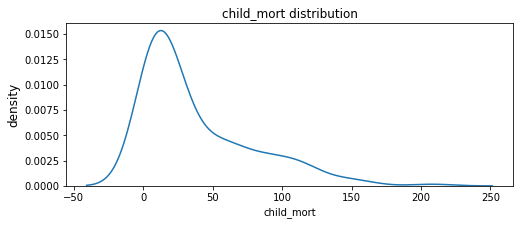

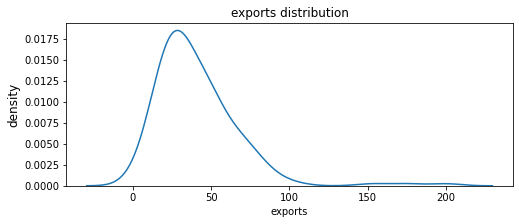

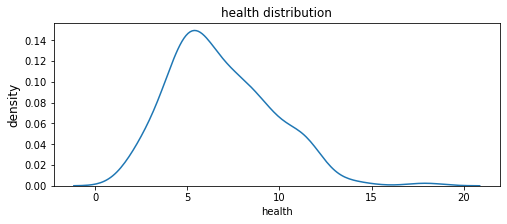

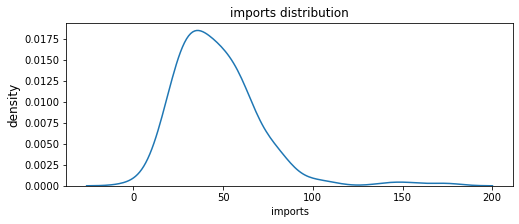

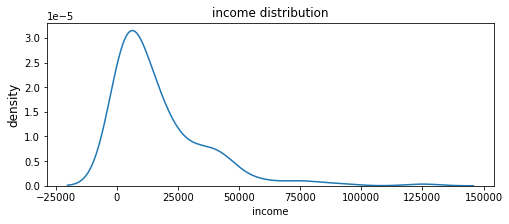

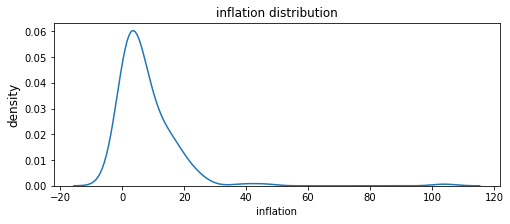

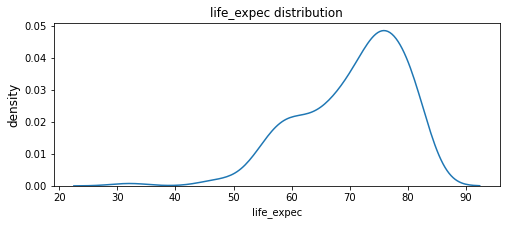

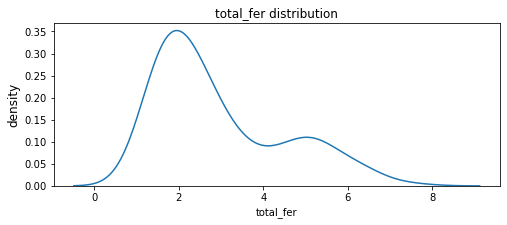

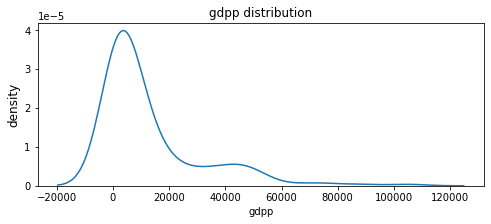

In [9]:
for col in df.columns:
    plt.figure(figsize=(8, 3))
    sns.kdeplot(x=df[col])
    plt.title('{} distribution'.format(col), size=12)
    plt.ylabel('density', size=12)
    plt.show()

# <center>2. Elbow method</center>

#### If clusterization is done by Kmeans, one peculiar input parameter that has to be prior specified is the number of clusters 'k'. Here, elbow method will be applied for this puropse. Since euclidean distance is the basis of Kmeans, this process require adequate scaling. 

In [10]:
scaled_df = df.copy()
for col in scaled_df.columns:
    scaled_df[col] = scaled_df[col].apply(lambda x: (x-df[col].mean())/df[col].std())

inertia = []
for k in list(range(2,20)):
    kmeans = KMeans(n_clusters=k, random_state=666)
    kmeans = kmeans.fit(scaled_df)
    u = kmeans.inertia_
    inertia.append(u)

Text(0.5, 1.0, 'Inertia Plot per k')

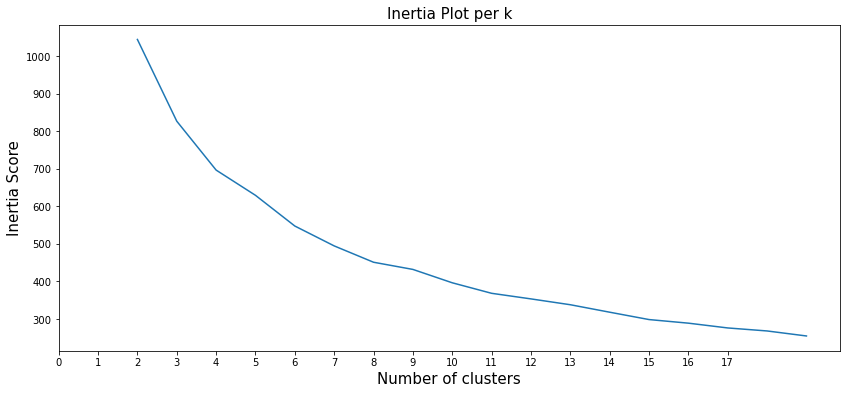

In [11]:
plt.figure(figsize=(14, 6))
xx = np.arange(len(range(2,20)))
plt.plot(list(range(2,20)), inertia)
plt.xticks(xx)
plt.xlabel('Number of clusters', size=15)
plt.ylabel('Inertia Score', size=15)
plt.title("Inertia Plot per k", size=15)

#### Arguably, k = 3 paramteter will be adopted (larger 'k' produced in fact sparse clusters).

# <center>3. Kmeans clustering</center>

### <center> Defining the number of principal components</center>

#### Applying PCA before Kmeans is touted to be beneficial. Firstly, let's establish the the number of principal components that conveys at least 95 procent of variance.

In [12]:
pca = PCA(n_components=9, svd_solver='full')
pca.fit(scaled_df)

explained_variance_ratio=0
components = 0
while explained_variance_ratio < 0.95:
    explained_variance_ratio += pca.explained_variance_ratio_[components]
    components += 1
print('no. of principal components: {}'.format(components))
print('explained_variance_ratio: {}'.format(explained_variance_ratio))

no. of principal components: 6
explained_variance_ratio: 0.9701523224082287


### <center>Clusterization</center>

#### Okay! We are finally ready to conduct the essential clusterization.

In [13]:
pipe = make_pipeline(StandardScaler(), 
                     PCA(n_components=6, svd_solver='full'), 
                     KMeans(n_clusters=3, random_state=666, n_init=100))
pipe.fit(df)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=6, svd_solver='full')),
                ('kmeans', KMeans(n_clusters=3, n_init=100, random_state=666))])

In [14]:
clusters = pipe.predict(df)

#### Number of countries assigned to each cluster can be seen below:

In [15]:
df['cluster'] = clusters.tolist()
df['cluster'].value_counts()

0    85
1    46
2    36
Name: cluster, dtype: int64

In [16]:
df.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster
country,,,,,,,,,,
Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,1
Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,0
Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,0
Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,1
Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,0


# <center>4. The clusters</center>

#### Let's investigate a little into the characteristics of each cluster.

In [17]:
cluster_means = pd.concat([df.groupby(['cluster'])['gdpp'].mean()], axis=1)
for col in df.columns:
    if (col=='gdpp')|(col=='cluster'):
        continue
    cluster_means = pd.concat([cluster_means, df.groupby(['cluster'])[col].mean()], axis=1)
cluster_means

,gdpp,child_mort,exports,health,imports,income,inflation,life_expec,total_fer
cluster,,,,,,,,,
0,6484.847059,22.287059,40.283400,6.225647,47.518422,12317.294118,7.616424,72.629412,2.314235
1,1826.130435,93.841304,28.837174,6.346957,42.128261,3738.978261,12.087065,59.232609,5.054348
2,42494.444444,5.000000,58.738889,8.807778,51.491667,45672.222222,2.671250,80.127778,1.752778


#### Within-cluster means can be seen above. Clusters corresponds to developing, underdeveloped and developed countries.

### <center>Visualization</center>

#### Again PCA is deployed, this time to visualize our clusters using first two principal components :

Explained variance ratio: 0.6313336543771412


<Figure size 432x288 with 0 Axes>

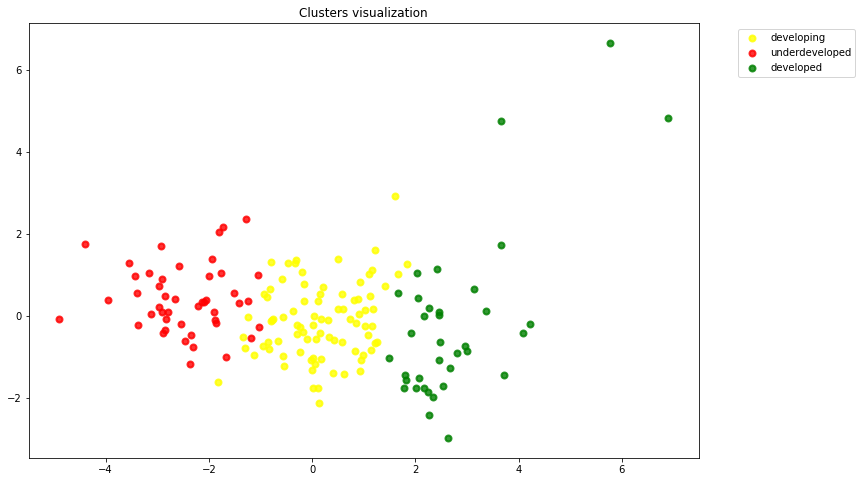

In [18]:
X = scaled_df
y_num = clusters

cluster_names = ['developing', 'underdeveloped', 'developed']

pca = PCA(n_components=2, random_state = 666)
X_r = pca.fit(scaled_df).transform(scaled_df)

print('Explained variance ratio: {}'.format(pca.explained_variance_ratio_.sum()))

plt.figure()
plt.figure(figsize=(12,8))
colors = ['yellow', 'red', 'green']
lw = 2

for color, i, cluster_name in zip(colors, [0, 1, 2], cluster_names):
    plt.scatter(X_r[clusters == i, 0], X_r[clusters == i, 1], color=color, alpha=.8, lw=lw,label=cluster_name)

plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.6)   
plt.title('Clusters visualization')
plt.show()

#### Finally, let's change the cluster labels accordingly :

In [19]:
df['cluster'] = df['cluster'].apply(lambda x: 'developing' if x==0 else ('underdeveloped' if x==1 else 'developed'))

In [20]:
df.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster
country,,,,,,,,,,
Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,underdeveloped
Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,developing
Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,developing
Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,underdeveloped
Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,developing


In [21]:
df.cluster.value_counts()

developing        85
underdeveloped    46
developed         36
Name: cluster, dtype: int64